1. Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность.
2. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00


План по улучшению:
 - Составить несколько моделей с разными параметрами;
 - Поискать оптимальные варианты;
 - Применить несколько разных оптимайзеров;
 - Применить callback;
 - Сделать сборку предсказаний из нескольких моделей (Идея обучить одну из моделей на обратном векторе);

In [ ]:
# from __future__ import absolute_import,division, print_function, unicode_literals

#TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, to_ordinal
from tensorflow.keras.models import load_model
#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import keras_tuner as kt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

print(tf.__version__)

2.12.0


## Импортируем Fashion MNIST датасет

In [ ]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize.
train_images = (train_images / 255)
test_images = (test_images / 255)

# Flatten.
# train_images = train_images.reshape((-1, 784)) # можно использовать np.ravel()
# test_images = test_images.reshape((-1, 784))

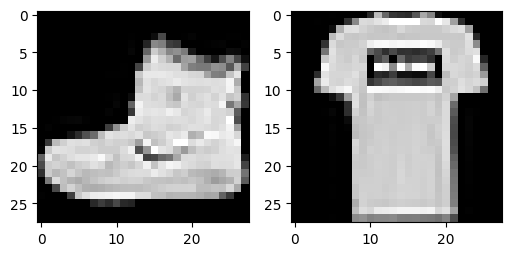

In [ ]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_images[1], cmap='gray')

Датасет содержит следующие классы:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Каждому классу обозначенному цифрой мы можем присвоить текстовое значение -

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Для процесса обучения нейронной сети нам важно перевести данные из диапазона от 0 до 255 в диапазон от 0 до 1:

### Определение слоев

Давайте создадим 3 слоя нейронной сети с помощью функционала Keras.layers

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
])
config = model.get_config()
model.save_weights('fashion_weights.h5')

313/313 - 2s - loss: 0.3550 - accuracy: 0.8889 - 2s/epoch - 5ms/step

Test accuracy: 0.8888999819755554
313/313 [==============================] - 1s 3ms/step


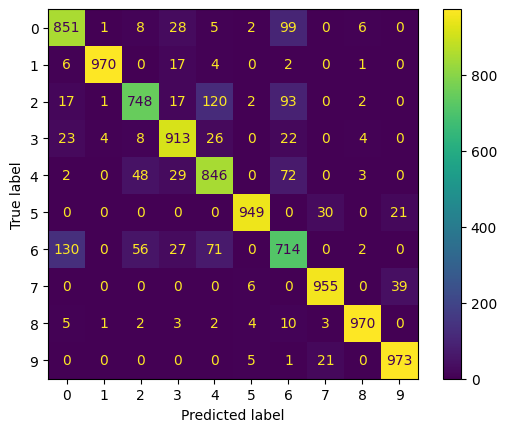

In [ ]:
model = model.from_config(config)
model.load_weights('fashion_weights.h5')


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size = 250, epochs=25, verbose=0)
  # model.fit(train_images, train_labels, batch_size = 250, epochs=el, verbose=0, validation_data=(test_images, test_labels))
  # model.fit(train_images, train_labels, batch_size = 10, epochs=10, verbose=0, validation_data=(test_images, test_labels), callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

In [ ]:
def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
  precision = precision_score(y_true, y_pred, labels=labels, average=None)
  recall = recall_score(y_true, y_pred, labels=labels, average=None)
  for i, el in enumerate(zip(precision, recall)):
    print(f'Класс - {i}, точность - {el[0]:.3f}, полнота - {el[1]:.3f}')

In [ ]:
recall_precision(test_labels, y_pred)

Класс - 0, точность - 0.823, полнота - 0.851
Класс - 1, точность - 0.993, полнота - 0.970
Класс - 2, точность - 0.860, полнота - 0.748
Класс - 3, точность - 0.883, полнота - 0.913
Класс - 4, точность - 0.788, полнота - 0.846
Класс - 5, точность - 0.980, полнота - 0.949
Класс - 6, точность - 0.705, полнота - 0.714
Класс - 7, точность - 0.946, полнота - 0.955
Класс - 8, точность - 0.982, полнота - 0.970
Класс - 9, точность - 0.942, полнота - 0.973


После перебора всех параметров нейросети, созданной на уроке можно уверенно заключить:
- Улучшить ее работу только изменяя параметры невозможно.

- Не улучшает ситуацию последовательное обучение с использованием различных входных пакетов.

- Не удалось также создать сеть с другим количеством слоёв существенно превосходящую образец.

- Не оправдала себя идея использовать для обучения зеркально (горизонтально или вертикально) отраженные изображения.

**-Единственный вариант давший небольшие улучшения это использование комбинации 2х сетей, сети образца и сети с параметрами, которая "заточена" максимально хорошо предсказывать самый плохо определяемый класс.**

313/313 - 1s - loss: 0.3550 - accuracy: 0.8889 - 691ms/epoch - 2ms/step

Test accuracy: 0.8888999819755554
313/313 [==============================] - 1s 2ms/step
313/313 - 1s - loss: 0.3445 - accuracy: 0.8887 - 1s/epoch - 3ms/step

Test accuracy: 0.888700008392334
313/313 [==============================] - 1s 2ms/step
0.8972
Класс - 0, точность - 0.837, полнота - 0.868
Класс - 1, точность - 0.995, полнота - 0.977
Класс - 2, точность - 0.872, полнота - 0.761
Класс - 3, точность - 0.879, полнота - 0.931
Класс - 4, точность - 0.827, полнота - 0.824
Класс - 5, точность - 0.983, полнота - 0.947
Класс - 6, точность - 0.713, полнота - 0.747
Класс - 7, точность - 0.949, полнота - 0.965
Класс - 8, точность - 0.979, полнота - 0.976
Класс - 9, точность - 0.948, полнота - 0.976
None


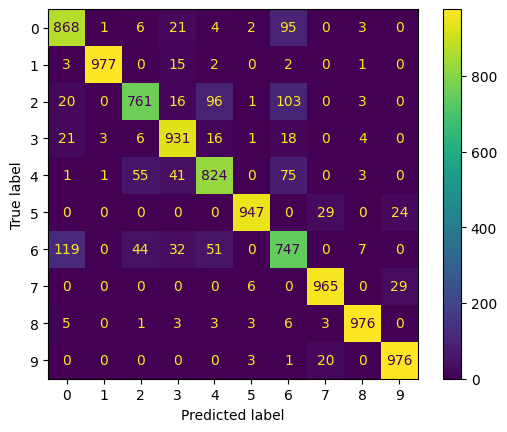

In [ ]:
# Создаем словарь который будет содержать модель сети и параметры для обучения
models = dict()
models[0] = [keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
]), tf.keras.optimizers.Adam(learning_rate=0.001), 250]
models[1] = [keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='gelu', name='hiden_two'),
    keras.layers.Dense(64, activation='sigmoid', name='hiden_three'),
    keras.layers.Dense(64, activation='selu', name='hiden_four'),
    keras.layers.Dense(10, name='output')]), tf.keras.optimizers.AdamW(learning_rate=0.001), 450]
# Список для сохранения результатов
result = list()
# Формируем сеть.
for key, param in models.items():
  # Загружаем параметры
  model, opt, batch = param[0], param[1], param[2]
  # Загружаем входные веса, чтобы хоть как-то "уравнять" результаты работы
  model.load_weights('fashion_weights.h5')
  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.fit(train_images, train_labels, batch_size=batch, epochs=25, verbose=0)
  # Получаем предварительную метрику
  test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
  print('\nTest accuracy:', test_acc)
  probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
  # Сохраняем массив с вероятностями
  result.append(probability_model.predict(test_images))
# Получаем финишное предсказание суммируя два массива с вероятностями
y_pred = np.argmax(sum(result), axis=1)
# Окончательная метрика качества
print(accuracy_score(test_labels, y_pred))
# Распределение предсказаний по классам
print(recall_precision(test_labels, y_pred))
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)


Интересным показался модуль Keras-tuner, для подбора оптимальных параметорв сети. Правда я не разобрался как можно с его помощью искать оптимальное число слоёв сети.

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=10, max_value=256, step=25)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


In [ ]:
tuner.search(train_images, train_labels, epochs=25, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f' layer is {best_hps.get("units")}')


